In [1]:

######## snakemake preamble start (automatically inserted, do not edit) ########
import sys; sys.path.extend(['c:\\work\\miniconda3\\envs\\cartography\\lib\\site-packages', 'C:\\work\\cartography\\notebooks']); import pickle; snakemake = pickle.loads(b'\x80\x03csnakemake.script\nSnakemake\nq\x00)\x81q\x01}q\x02(X\x05\x00\x00\x00inputq\x03csnakemake.io\nInputFiles\nq\x04)\x81q\x05(X\x1c\x00\x00\x00notebooks/Data/aligned.fastaq\x06X"\x00\x00\x00notebooks/dropped_Strains_zika.txtq\x07X)\x00\x00\x00notebooks/Data/zika-cartography_tree.jsonq\x08X\'\x00\x00\x00notebooks/Data/name_of_disease_zika.txtq\te}q\nX\x06\x00\x00\x00_namesq\x0b}q\x0csbX\x06\x00\x00\x00outputq\rcsnakemake.io\nOutputFiles\nq\x0e)\x81q\x0f(X%\x00\x00\x00notebooks/docs/FullViolinPlotZika.pngq\x10X&\x00\x00\x00notebooks/docs/FullScatterplotZika.pngq\x11X/\x00\x00\x00notebooks/docs/FullLinkedChartClickableZika.pngq\x12X0\x00\x00\x00notebooks/docs/FullLinkedChartClickableZika.htmlq\x13e}q\x14h\x0b}q\x15sbX\x06\x00\x00\x00paramsq\x16csnakemake.io\nParams\nq\x17)\x81q\x18}q\x19h\x0b}q\x1asbX\t\x00\x00\x00wildcardsq\x1bcsnakemake.io\nWildcards\nq\x1c)\x81q\x1d}q\x1eh\x0b}q\x1fsbX\x07\x00\x00\x00threadsq K\x01X\t\x00\x00\x00resourcesq!csnakemake.io\nResources\nq")\x81q#(K\x01K\x01e}q$(h\x0b}q%(X\x06\x00\x00\x00_coresq&K\x00N\x86q\'X\x06\x00\x00\x00_nodesq(K\x01N\x86q)uh&K\x01h(K\x01ubX\x03\x00\x00\x00logq*csnakemake.io\nLog\nq+)\x81q,}q-h\x0b}q.sbX\x06\x00\x00\x00configq/}q0X\x04\x00\x00\x00ruleq1X\x08\x00\x00\x00run_zikaq2X\x0f\x00\x00\x00bench_iterationq3NX\t\x00\x00\x00scriptdirq4X\x1d\x00\x00\x00C:\\work\\cartography\\notebooksq5ub.'); from snakemake.logging import logger; logger.printshellcmds = True; import os; os.chdir('C:\work\cartography');
######## snakemake preamble end #########


# This is Cartography put together into one place. 

## Modules to add to run this code:

- [BioPython][1]
- [Pandas][2]
- [Numpy][3]
- [Altair][4]
- [Seaborn][5]
- [Scikit-Learn][6]
- [UMAP][7]
- json
- nextstrain-augur
- statsmodels
[1]:https://biopython.org/wiki/Download
[2]:https://pandas.pydata.org/pandas-docs/version/0.23.3/install.html
[3]:https://docs.scipy.org/doc/numpy/user/quickstart.html
[4]:https://altair-viz.github.io/getting_started/installation.html
[5]:https://seaborn.pydata.org/installing.html
[6]:https://scikit-learn.org/stable/install.html
[7]:https://umap-learn.readthedocs.io/en/latest/


# Imports Section 

In [2]:
import pandas as pd
import altair as alt
import numpy as np
from scipy.spatial.distance import squareform, pdist
from Bio import SeqIO
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from augur.utils import json_to_tree
import json
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import umap
from scipy.stats import linregress
from pathlib import Path
import statsmodels
import statistics
import matplotlib.pyplot as plt
from Helpers import get_euclidean_data_frame, get_hamming_distances, linking_tree_with_plots_brush
from Helpers import linking_tree_with_plots_clickable
from Helpers import scatterplot_xyvalues, scatterplot_tooltips, scatterplot_with_tooltip_interactive
import selenium
from selenium.webdriver import Chrome 
%matplotlib inline

C:\Work\Miniconda3\envs\cartography\lib\site-packages\umap\spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


In [3]:
from selenium import webdriver

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

browser = webdriver.Chrome(options=chrome_options)

## Pathogen-specific variables

Consider consolidating these into a single configuration file that can be passed to the notebook as a command line argument for more scriptable generation of these figures.

# Flu Specific Variables

In [4]:
path = snakemake.input[0]
dropped_strains = [line.rstrip('\n') for line in open(snakemake.input[1],"r")]
tree_path = snakemake.input[2]
if(len(snakemake.input) > 4):
    clades_to_plot = [line.rstrip('\n') for line in open(snakemake.input[len(snakemake.input)-2],"r")]
f = open(snakemake.input[len(snakemake.input)-1], "r")
virus_name = f.read()

# Zika Specific Variables 

### Reading in the Fasta File
- I used BioPython to parse the Fasta file into two numpy Arrays: Genomes and Strains. 

In [5]:
#work on making this work
strains = []
genomes = []
for record in SeqIO.parse(path, "fasta"):
    if(record.id not in dropped_strains):
        strains.append(str(record.id))
        genomes.append(str(record.seq))

#### Checking to make sure the file I picked is a aligned Fasta file / is the file I wanted

In [6]:
len(strains)
print(len(genomes[0]) == len(genomes[1]))
print(len(genomes))

True
691


In [7]:
strains[:5]

['DOM/2016/MA_WGS16_020',
 'USVI/41/2016',
 'mex39/Mexico/2016',
 'DOM/2016/MA_WGS16_024',
 'DOM/2016/BB_0208']

In [8]:
genomes_df = pd.DataFrame(genomes)
strains_df = pd.DataFrame(strains)

In [9]:
genomes_missing_bases = []
for x in genomes:
    x = re.sub(r'[^AGCT]', '5', x)
    numberOfN = x.count("5")
    genomes_missing_bases.append(numberOfN)

In [10]:
genomes_missing_bases_df = pd.DataFrame(genomes_missing_bases)
genomes_missing_bases_df = genomes_missing_bases_df.merge(strains_df, how='outer', left_index = True, right_index = True)
genomes_missing_bases_df.columns = ["bases missing", "strain"]

# Missing Bases

In [11]:
genomes_missing_bases_df.head()

bases missing                 strain
0           7732  DOM/2016/MA_WGS16_020
1           1308           USVI/41/2016
2            718      mex39/Mexico/2016
3            206  DOM/2016/MA_WGS16_024
4             17       DOM/2016/BB_0208

In [12]:
alt.Chart(genomes_missing_bases_df).mark_bar().encode(
    alt.X("bases missing:Q", bin=True),
    y="count()"
)

<VegaLite 3 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [13]:
# Also, consider storing the list of dropped strains in a text file outside of the notebook.
dropped_strains.extend(list(genomes_missing_bases_df[genomes_missing_bases_df["bases missing"]>1000]["strain"]))

In [14]:
#work on making this work
strains = []
genomes = []
for record in SeqIO.parse(path, "fasta"):
    if(record.id not in dropped_strains):
        strains.append(str(record.id))
        genomes.append(str(record.seq))

In [15]:
len(strains)
print(len(genomes[0]) == len(genomes[1]))
print(len(genomes))

True
534


In [16]:
strains[:5]

['mex39/Mexico/2016',
 'DOM/2016/MA_WGS16_024',
 'DOM/2016/BB_0208',
 'DOM/2016/MA_WGS16_007',
 'Yokohama/1/2016']

In [17]:
genomes_df = pd.DataFrame(genomes)
strains_df = pd.DataFrame(strains)
genomes_df.columns = ["strain"]

# Creating the Distance Matrix
- I used Hamming Distance to find the pairwise distance between each genome and each other genome, effectively creating a similarity/distance matrix
    - In my Hamming Distance method, I only counted something as a different if it was a mismatch between the nucleotides (A,G,C, or T), not gaps (as that was throwing off the algorithm too much for smaller strains)
- I then used Seaborn to generate a heatmap to make sure the matrix looked correct

In [18]:
%%time
# Try to load an existing distance matrix. Create it, if it doesn't already exist.
"""try:
    # The index should be the first column and correspond to strain name for the row.
    similarity_matrix = pd.read_csv(distance_matrix_file, index_col=0)
    print("Loaded existing distance matrix")
except FileNotFoundError:
    print("Could not find existing distance matrix, creating it now", end="...")
"""    
# Calculate Hamming distances.
hamming_distances = get_hamming_distances(genomes)

# Convert distinct pairwise distances into the more redundant but more interpretable square matrix.
similarity_matrix = squareform(hamming_distances)

# Convert the numpy matrix to a pandas data frame with strain annotations for rows and columns.
similarity_matrix = pd.DataFrame(
    similarity_matrix,
    columns=strains,
    index=strains
)

# Write out the resulting data frame to cache distance calculations.
# Keep the index in the output file, so it is immediately available on read.
#similarity_matrix.to_csv(distance_matrix_file)
print("done!")

done!
Wall time: 11.4 s


In [19]:
similarity_matrix

mex39/Mexico/2016  DOM/2016/MA_WGS16_024  \
mex39/Mexico/2016                      0                     66   
DOM/2016/MA_WGS16_024                 66                      0   
DOM/2016/BB_0208                      68                     14   
DOM/2016/MA_WGS16_007                 69                     16   
Yokohama/1/2016                       67                     13   
...                                  ...                    ...   
USVI/32/2016                          65                     53   
USVI/27/2016                          72                     61   
USVI/19/2016                          75                     23   
USVI/20/2016                          80                     27   
NIC/5256_13A1/2016                    48                     58   

                       DOM/2016/BB_0208  DOM/2016/MA_WGS16_007  \
mex39/Mexico/2016                    68                     69   
DOM/2016/MA_WGS16_024                14                     16   
DOM/2016/BB_0208                      0                      5   
DOM/2016/MA_WGS16_007                 5                      0   
Yokohama/1/2016                      15                     17   
...                                 ...                    ...   
USVI/32/2016                         54                     56   
USVI/27/2016                         62                     64   
USVI/19/2016                         24                     27   
USVI/20/2016                         28                     31   
NIC/5256_13A1/2016                   58                     58   

                       Yokohama/1/2016  DOM/2016/BB_0180  DOM/2016/BB_0115  \
mex39/Mexico/2016                   67                64                69   
DOM/2016/MA_WGS16_024               13                12                15   
DOM/2016/BB_0208                    15                14                17   
DOM/2016/MA_WGS16_007               17                15                18   
Yokohama/1/2016                      0                13                16   
...                                ...               ...               ...   
USVI/32/2016                        53                50                54   
USVI/27/2016                        61                58                62   
USVI/19/2016                        23                22                24   
USVI/20/2016                        28                26                28   
NIC/5256_13A1/2016                  59                56                61   

                       Dominican_Republic/2016/PD1  Haiti/2016/PD  \
mex39/Mexico/2016                               65             62   
DOM/2016/MA_WGS16_024                           11              8   
DOM/2016/BB_0208                                13             10   
DOM/2016/MA_WGS16_007                           15             12   
Yokohama/1/2016                                 12              9   
...                                            ...            ...   
USVI/32/2016                                    52             49   
USVI/27/2016                                    60             57   
USVI/19/2016                                    22             19   
USVI/20/2016                                    26             23   
NIC/5256_13A1/2016                              57             53   

                       mosquito/Haiti/1855/2016  ...  MEX/2016/mex47  \
mex39/Mexico/2016                            63  ...              47   
DOM/2016/MA_WGS16_024                        15  ...              50   
DOM/2016/BB_0208                             17  ...              53   
DOM/2016/MA_WGS16_007                        19  ...              55   
Yokohama/1/2016                              16  ...              51   
...                                         ...  ...             ...   
USVI/32/2016                                 51  ...              53   
USVI/27/2016                                 59  ...              60   
USVI/19/201

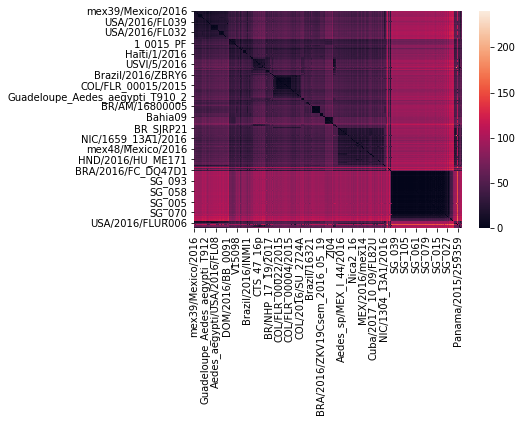

In [20]:
sns.heatmap(similarity_matrix)

# Creating the Phylogenetic Tree in Altair
- I used Altair to make this tree (Documentation linked [here][1]
- I opened and imported the json from a build from NextStrain ([flu][2], [zika][3], etc)
- The data from the JSON and the Data from the tree are usually a little different, so after merging the two dataframes you may get some errors.

[1]: https://altair-viz.github.io/index.html
[2]: https://github.com/nextstrain/seasonal-flu
[3]: https://altair-viz.github.io/index.html

In [21]:
with open(tree_path) as fh:
    json_tree_handle = json.load(fh)

In [22]:
tree = json_to_tree(json_tree_handle)

In [23]:
tree

Clade(branch_length=0, clade=1244, name='NODE_0000693', numdate=2009.854880484779, strain='NODE_0000693', yvalue=610.4904443384098)

In [24]:
node_data = [
    {
        "strain": node.name,
        "date": node.attr["num_date"],
        "y": node.yvalue,
        "region": node.attr["region"],
        "country": node.attr["country"],
        "parent_date": node.parent is not None and node.parent.attr["num_date"] or node.attr["num_date"],
        "parent_y": node.parent is not None and node.parent.yvalue or node.yvalue,
        "clade_membership" : node.attr['clade_membership']
    }
    for node in tree.find_clades(terminal=True)
]

In [25]:
node_data[10]

{'strain': 'SI_BKK05',
 'date': 2016.8651608487337,
 'y': 667,
 'region': 'southeast_asia',
 'country': 'thailand',
 'parent_date': 2015.7342325183038,
 'parent_y': 658.4254471807071,
 'clade_membership': 'c2'}

In [26]:
node_df = pd.DataFrame(node_data)

In [27]:
node_df.head()

strain         date    y          region    country  \
0              SG_021  2016.703628  677  southeast_asia  singapore   
1            SI_BKK06  2017.684463  676  southeast_asia   thailand   
2               BKK07  2017.750171  675  southeast_asia   thailand   
3   Thailand/1610acTw  2016.835044  674  southeast_asia   thailand   
4  Thai/KngSG/17_D501  2017.920087  673  southeast_asia   thailand   

   parent_date   parent_y clade_membership  
0  2012.306769  676.50000       unassigned  
1  2012.306769  676.50000       unassigned  
2  2014.673044  674.03125               c2  
3  2015.134275  673.06250               c2  
4  2015.822154  672.12500               c2

In [28]:
node_df["y"] = node_df["y"].max() - node_df["y"]

In [29]:
node_df["parent_y"] = node_df["parent_y"].max() - node_df["parent_y"]

In [30]:
node_df.shape

(677, 8)

In [31]:
node_df.head()

strain         date  y          region    country  parent_date  \
0              SG_021  2016.703628  0  southeast_asia  singapore  2012.306769   
1            SI_BKK06  2017.684463  1  southeast_asia   thailand  2012.306769   
2               BKK07  2017.750171  2  southeast_asia   thailand  2014.673044   
3   Thailand/1610acTw  2016.835044  3  southeast_asia   thailand  2015.134275   
4  Thai/KngSG/17_D501  2017.920087  4  southeast_asia   thailand  2015.822154   

   parent_y clade_membership  
0   0.00000       unassigned  
1   0.00000       unassigned  
2   2.46875               c2  
3   3.43750               c2  
4   4.37500               c2

In [32]:
node_df["region"].unique()

array(['southeast_asia', 'china', 'oceania', 'north_america',
       'south_america', 'africa', 'japan_korea'], dtype=object)

In [33]:
# Reannotate clades that we aren't interested in as "other" to simplify color assignment in visualizations.
try:
    node_df["clade_membership_color"] = node_df["clade_membership"].apply(lambda clade: clade if clade in clades_to_plot else "other")
except:
    node_df["clade_membership_color"] = node_df["clade_membership"]
    print("clades_to_plot undefined")

clades_to_plot undefined


In [34]:
indices_to_drop = similarity_matrix[~similarity_matrix.index.isin(node_df["strain"])].dropna(how = 'all')
similarity_matrix = similarity_matrix[similarity_matrix.index.isin(node_df["strain"])].dropna(how = 'all')
similarity_matrix = similarity_matrix.drop(indices_to_drop.index, axis=1)
similarity_matrix

mex39/Mexico/2016  DOM/2016/MA_WGS16_024  \
mex39/Mexico/2016                      0                     66   
DOM/2016/MA_WGS16_024                 66                      0   
DOM/2016/BB_0208                      68                     14   
DOM/2016/MA_WGS16_007                 69                     16   
Yokohama/1/2016                       67                     13   
...                                  ...                    ...   
USVI/32/2016                          65                     53   
USVI/27/2016                          72                     61   
USVI/19/2016                          75                     23   
USVI/20/2016                          80                     27   
NIC/5256_13A1/2016                    48                     58   

                       DOM/2016/BB_0208  DOM/2016/MA_WGS16_007  \
mex39/Mexico/2016                    68                     69   
DOM/2016/MA_WGS16_024                14                     16   
DOM/2016/BB_0208                      0                      5   
DOM/2016/MA_WGS16_007                 5                      0   
Yokohama/1/2016                      15                     17   
...                                 ...                    ...   
USVI/32/2016                         54                     56   
USVI/27/2016                         62                     64   
USVI/19/2016                         24                     27   
USVI/20/2016                         28                     31   
NIC/5256_13A1/2016                   58                     58   

                       Yokohama/1/2016  DOM/2016/BB_0180  DOM/2016/BB_0115  \
mex39/Mexico/2016                   67                64                69   
DOM/2016/MA_WGS16_024               13                12                15   
DOM/2016/BB_0208                    15                14                17   
DOM/2016/MA_WGS16_007               17                15                18   
Yokohama/1/2016                      0                13                16   
...                                ...               ...               ...   
USVI/32/2016                        53                50                54   
USVI/27/2016                        61                58                62   
USVI/19/2016                        23                22                24   
USVI/20/2016                        28                26                28   
NIC/5256_13A1/2016                  59                56                61   

                       Dominican_Republic/2016/PD1  Haiti/2016/PD  \
mex39/Mexico/2016                               65             62   
DOM/2016/MA_WGS16_024                           11              8   
DOM/2016/BB_0208                                13             10   
DOM/2016/MA_WGS16_007                           15             12   
Yokohama/1/2016                                 12              9   
...                                            ...            ...   
USVI/32/2016                                    52             49   
USVI/27/2016                                    60             57   
USVI/19/2016                                    22             19   
USVI/20/2016                                    26             23   
NIC/5256_13A1/2016                              57             53   

                       mosquito/Haiti/1855/2016  ...  MEX/2016/mex33  \
mex39/Mexico/2016                            63  ...              48   
DOM/2016/MA_WGS16_024                        15  ...              53   
DOM/2016/BB_0208                             17  ...              54   
DOM/2016/MA_WGS16_007                        19  ...              55   
Yokohama/1/2016                              16  ...              54   
...                                         ...  ...             ...   
USVI/32/2016                                 51  ...              52   
USVI/27/2016                                 59  ...              61   
USVI/19/201

In [35]:
node_df.head()

strain         date  y          region    country  parent_date  \
0              SG_021  2016.703628  0  southeast_asia  singapore  2012.306769   
1            SI_BKK06  2017.684463  1  southeast_asia   thailand  2012.306769   
2               BKK07  2017.750171  2  southeast_asia   thailand  2014.673044   
3   Thailand/1610acTw  2016.835044  3  southeast_asia   thailand  2015.134275   
4  Thai/KngSG/17_D501  2017.920087  4  southeast_asia   thailand  2015.822154   

   parent_y clade_membership clade_membership_color  
0   0.00000       unassigned             unassigned  
1   0.00000       unassigned             unassigned  
2   2.46875               c2                     c2  
3   3.43750               c2                     c2  
4   4.37500               c2                     c2

## Checking for Outliers in Pairwise Distance

In [36]:
mean_distances = similarity_matrix.mean().reset_index(name="mean_distance").rename(columns={"index": "strain"})

In [37]:
mean_distances.head()

strain  mean_distance
0      mex39/Mexico/2016      70.236295
1  DOM/2016/MA_WGS16_024      54.555766
2       DOM/2016/BB_0208      56.502836
3  DOM/2016/MA_WGS16_007      57.544423
4        Yokohama/1/2016      55.784499

In [38]:
alt.Chart(mean_distances, height=150).mark_boxplot().encode(
    x = alt.X('mean_distance', title="mean of pairwise distances"),
    tooltip = ["strain"]
)

<VegaLite 3 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


# Running PCA on Scaled and Centered Data
- I treated each nucleotide as a "site", or dimension, and found the probability of having a certain nucleotide given the frequency of that letter at that site.
- I used [this paper][1] as my source 
- The equation is as follows where C is the matrix of dimensions, M is the mean, and p is the frequency of a nucleotide at that given site. 
![](https://journals.plos.org/plosgenetics/article/file?type=thumbnail&id=info:doi/10.1371/journal.pgen.0020190.e003)

In [39]:
numbers = genomes[:]
for i in range(0,len(genomes)):
    numbers[i] = re.sub(r'[^AGCT]', '5', numbers[i])
    numbers[i] = list(numbers[i].replace('A','1').replace('G','2').replace('C', '3').replace('T','4'))
    numbers[i] = [int(j) for j in numbers[i]]
genomes_df = pd.DataFrame(numbers)
genomes_df.columns = ["Site " + str(k) for k in range(0,len(numbers[i]))]

In [40]:
genomes_df.head()

Site 0  Site 1  Site 2  Site 3  Site 4  Site 5  Site 6  Site 7  Site 8  \
0       2       1       1       4       3       1       2       1       3   
1       5       5       5       5       5       5       5       5       5   
2       5       5       1       4       3       1       2       1       3   
3       5       5       5       5       5       5       5       5       5   
4       5       5       1       4       3       1       2       1       3   

   Site 9  ...  Site 10759  Site 10760  Site 10761  Site 10762  Site 10763  \
0       4  ...           5           5           5           5           5   
1       5  ...           5           5           5           5           5   
2       4  ...           5           5           5           5           5   
3       5  ...           5           5           5           5           5   
4       4  ...           3           2           2           3           2   

   Site 10764  Site 10765  Site 10766  Site 10767  Site 10768  
0           5           5           5           5           5  
1           5           5           5           5           5  
2           5           5           5           5           5  
3           5           5           5           5           5  
4           2           3           3           2           2  

[5 rows x 10769 columns]

In [41]:
#performing PCA on my pandas dataframe 
pca = PCA(n_components=10,svd_solver='full') #can specify n, since with no prior knowledge, I use None
principalComponents = pca.fit_transform(genomes_df)

In [42]:
# Create a data frame from the PCA embedding.
principalDf = pd.DataFrame(data = principalComponents, columns = ["PCA" + str(i) for i in range(1,11)])

# Annotate rows by their original strain names. PCA rows are in the same order as
# the `genomes` rows which are in the same order as the `strains` rows.
principalDf["strain"] = strains

In [43]:
df = pd.concat([pd.DataFrame(np.arange(1,11)), pd.DataFrame([round(pca.explained_variance_ratio_[i],4) for i in range(0,len(pca.explained_variance_ratio_))])], axis = 1)
df.columns = ['principal components','explained variance']
df

principal components  explained variance
0                     1              0.3926
1                     2              0.1120
2                     3              0.0469
3                     4              0.0417
4                     5              0.0382
5                     6              0.0259
6                     7              0.0254
7                     8              0.0230
8                     9              0.0196
9                    10              0.0176

In [44]:
alt.Chart(df).mark_point().encode(
    x='principal components:Q',
    y='explained variance:Q'
)

<VegaLite 3 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [45]:
merged_pca_df = principalDf.merge(node_df, on="strain")

In [46]:
merged_pca_df.head()

PCA1       PCA2       PCA3      PCA4      PCA5      PCA6      PCA7  \
0  17.802289   4.968511 -12.042926  3.222568 -2.802429  6.860210 -4.157783   
1   8.365290  16.331752  -4.849178 -1.441106 -3.544051  3.798773 -4.883683   
2 -15.531289  -4.921779  -0.415581 -0.255915 -0.037770 -0.160553 -0.143104   
3  40.019343 -10.448338  -2.031868 -5.411839 -9.075143 -2.623867  4.485669   
4 -17.136446  -7.455020   0.432313 -0.624637 -0.669410 -0.049321 -0.199851   

       PCA8      PCA9      PCA10                 strain         date    y  \
0  6.562530  0.858142  14.646965      mex39/Mexico/2016  2016.517454  574   
1  3.701904 -6.899351  -1.097170  DOM/2016/MA_WGS16_024  2016.517454  393   
2 -0.834159  0.785739  -1.113369       DOM/2016/BB_0208  2016.303901  413   
3 -1.286956  2.709453   0.776484  DOM/2016/MA_WGS16_007  2016.358658  414   
4  1.562355 -1.776390   2.047959        Yokohama/1/2016  2016.386037  386   

          region             country  parent_date    parent_y  \
0  north_america              mexico  2015.017583  575.917969   
1  north_america  dominican_republic  2016.102272  393.000000   
2  north_america  dominican_republic  2016.097083  413.000000   
3  north_america  dominican_republic  2016.097083  413.000000   
4    japan_korea               japan  2015.722717  387.023438   

  clade_membership clade_membership_color  
0               c4                     c4  
1               c5                     c5  
2               c5                     c5  
3               c5                     c5  
4               c5                     c5

In [47]:
list_of_chart = linking_tree_with_plots_brush(merged_pca_df,['PCA1','PCA2','PCA3','PCA4'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(pca.explained_variance_ratio_[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(pca.explained_variance_ratio_[1]*100,2)) + ")",
                                          'PCA3 (Explained Variance : {}%'.format(round(pca.explained_variance_ratio_[2]*100,2)) + ")",
                                          'PCA4 (Explained Variance : {}%'.format(round(pca.explained_variance_ratio_[3]*100,2)) + ")"],
                                         "clade_membership:N",['strain','region'])
PCAFluBrush = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]

PCAFluBrush

<VegaLite 3 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


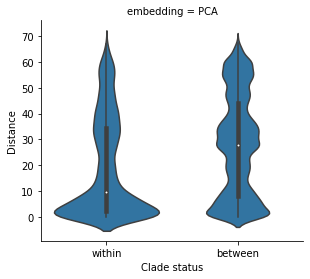

In [48]:
PCA_violin_df = get_euclidean_data_frame(merged_pca_df, "PCA1", "PCA2", "PCA")
g = sns.FacetGrid(
    PCA_violin_df,
    col="embedding",
    col_wrap=3,
    sharey=False,
    height=4
)
g = g.map(sns.violinplot, "clade_status", "distance", order=["within", "between"])
g.set_axis_labels("Clade status", "Distance")
plt.savefig("docs/PCAViolinPlot" + virus_name + ".png")

In [49]:
total_df = scatterplot_xyvalues(similarity_matrix.index, similarity_matrix, merged_pca_df, "PCA1", "PCA2", "PCA")
y_values = statsmodels.nonparametric.smoothers_lowess.lowess(
    total_df["euclidean"],
    total_df["genetic"],
    frac=0.6666666666666666,
    it=3,
    delta=0.0,
    is_sorted=False,
    missing='drop',
    return_sorted=True
)

PD_Y_values = pd.DataFrame(y_values)
PD_Y_values.columns = ["LOWESS_x", "LOWESS_y"]

regression = linregress(total_df["genetic"], total_df["euclidean"])
slope, intercept, r_value, p_value, std_err = regression

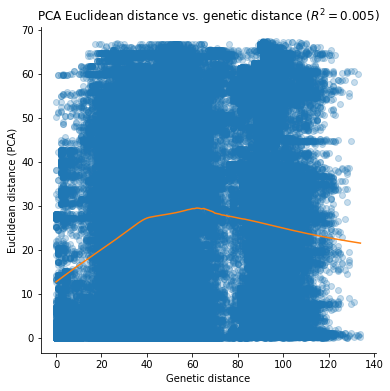

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df["genetic"], total_df["euclidean"], "o", alpha=0.25)
ax.plot(PD_Y_values["LOWESS_x"], PD_Y_values["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (PCA)")
ax.set_title("PCA Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (r_value ** 2))

sns.despine()
plt.savefig("docs/PCAScatterplotLOESS" + virus_name + ".png")

# Running MDS on the Dataset

In [51]:
embedding = MDS(n_components=10,metric=True,dissimilarity='precomputed')
X_transformed_mds = embedding.fit_transform(similarity_matrix)

In [52]:
raw_stress = embedding.stress_
normalized_stress = np.sqrt(raw_stress /((similarity_matrix.values.ravel() ** 2).sum() / 2))
print(normalized_stress.round(2))

0.04


In [53]:
MDS_df = pd.DataFrame(X_transformed_mds,columns=['MDS' + str(i) for i in range(1,11)])

In [54]:
MDS_df.shape

(529, 10)

In [55]:
# Annotate rows by their original strain names. The same logic from PCA holds here
# and for later embeddings.
MDS_df["strain"] = similarity_matrix.index

In [56]:
merged_mds_df = MDS_df.merge(node_df, on="strain")

In [57]:
merged_mds_df.head()

MDS1       MDS2       MDS3       MDS4       MDS5       MDS6  \
0 -13.887456   8.954108 -16.260057 -34.690097 -11.178295  12.676356   
1  13.431810 -22.799305  -2.371773  -4.992668   3.460144  -5.757748   
2  13.553881 -26.846804   0.411896  -5.465738  -1.063431  -6.663648   
3  15.027415 -24.311485  -1.031354  -4.280743   1.120298  -4.716696   
4  12.953820 -24.438493  -0.073483  -5.271038  -2.990574  -2.174656   

        MDS7      MDS8       MDS9      MDS10                 strain  \
0  16.144543  2.251098 -31.797135   2.713540      mex39/Mexico/2016   
1 -13.784433  2.880968 -21.989578  -3.116442  DOM/2016/MA_WGS16_024   
2 -10.667196  5.966197 -21.009647 -10.581508       DOM/2016/BB_0208   
3 -12.587370  6.336835 -21.954598 -14.896294  DOM/2016/MA_WGS16_007   
4 -11.712434  2.479570 -24.020709  -7.360086        Yokohama/1/2016   

          date    y         region             country  parent_date  \
0  2016.517454  574  north_america              mexico  2015.017583   
1  2016.517454  393  north_america  dominican_republic  2016.102272   
2  2016.303901  413  north_america  dominican_republic  2016.097083   
3  2016.358658  414  north_america  dominican_republic  2016.097083   
4  2016.386037  386    japan_korea               japan  2015.722717   

     parent_y clade_membership clade_membership_color  
0  575.917969               c4                     c4  
1  393.000000               c5                     c5  
2  413.000000               c5                     c5  
3  413.000000               c5                     c5  
4  387.023438               c5                     c5

In [58]:
chart_12_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'MDS1','MDS2',"MDS1","MDS2",['strain','clade_membership'],'clade_membership_color')
chart_34_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'MDS3','MDS4',"MDS3","MDS4",['strain','clade_membership'],'clade_membership_color')
chart_56_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'MDS5','MDS6',"MDS5","MDS6",['strain','clade_membership'],'clade_membership_color')
chart_12_mds|chart_34_mds|chart_56_mds

<VegaLite 3 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [59]:
chart_MDS = scatterplot_tooltips(similarity_matrix.index, similarity_matrix, merged_mds_df, "MDS1", "MDS2", "MDS", 4000)
chart_34_scatter = scatterplot_tooltips(similarity_matrix.index, similarity_matrix, merged_mds_df, "MDS3", "MDS4", "MDS", 4000)
chart_56_scatter = scatterplot_tooltips(similarity_matrix.index, similarity_matrix, merged_mds_df, "MDS5", "MDS6", "MDS", 4000)
chart_MDS | chart_34_scatter | chart_56_scatter

<VegaLite 3 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [60]:
total_df = scatterplot_xyvalues(similarity_matrix.index, similarity_matrix, merged_mds_df, "MDS1", "MDS2", "MDS")
y_values = statsmodels.nonparametric.smoothers_lowess.lowess(
    total_df["euclidean"],
    total_df["genetic"],
    frac=0.6666666666666666,
    it=3,
    delta=0.0,
    is_sorted=False,
    missing='drop',
    return_sorted=True
)

PD_Y_values = pd.DataFrame(y_values)
PD_Y_values.columns = ["LOWESS_x", "LOWESS_y"]

regression = linregress(total_df["genetic"], total_df["euclidean"])
slope, intercept, r_value, p_value, std_err = regression

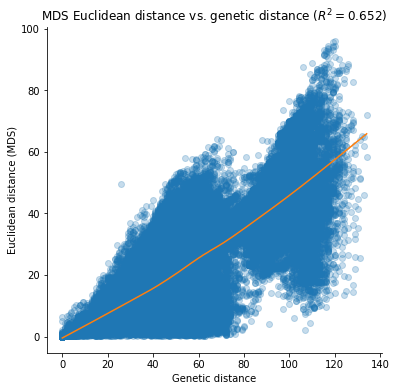

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df["genetic"], total_df["euclidean"], "o", alpha=0.25)
ax.plot(PD_Y_values["LOWESS_x"], PD_Y_values["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (MDS)")
ax.set_title("MDS Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (r_value ** 2))

sns.despine()
plt.savefig("docs/MDSScatterplotLOESS" + virus_name + ".png")

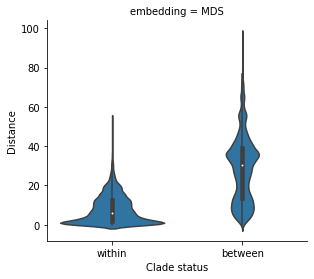

In [62]:
MDS_violin_df = get_euclidean_data_frame(merged_mds_df, "MDS1", "MDS2", "MDS")
g = sns.FacetGrid(
    MDS_violin_df,
    col="embedding",
    col_wrap=3,
    sharey=False,
    height=4
)
g = g.map(sns.violinplot, "clade_status", "distance", order=["within", "between"])
g.set_axis_labels("Clade status", "Distance")
plt.savefig("docs/MDSViolinPlot" + virus_name + ".png")

In [63]:
list_of_data_and_titles = ['MDS1','MDS2','MDS3','MDS4','MDS5','MDS6']
list_of_chart = linking_tree_with_plots_brush(
    merged_mds_df,
    list_of_data_and_titles,
    list_of_data_and_titles,
    'clade_membership_color',
    ["clade_membership","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[3]
chart

<VegaLite 3 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [64]:
chart.save("docs/MDS" + virus_name + "Brush.html")

# Running T-SNE on the Dataset 

In [65]:
embedding = TSNE(n_components=2,metric='precomputed',perplexity = 25.95)
X_transformed_tsne = embedding.fit_transform(similarity_matrix)

In [66]:
TSNE_df = pd.DataFrame(X_transformed_tsne,columns=['TSNE' + str(i) for i in range(1,3)])

In [67]:
TSNE_df["strain"] = similarity_matrix.index

In [68]:
TSNE_df.head()

TSNE1      TSNE2                 strain
0 -10.048105  21.967218      mex39/Mexico/2016
1 -26.630087  -8.409280  DOM/2016/MA_WGS16_024
2 -24.938646 -10.619441       DOM/2016/BB_0208
3 -24.839706 -10.681262  DOM/2016/MA_WGS16_007
4 -26.903944  -9.083067        Yokohama/1/2016

In [69]:
merged_tsne_df = TSNE_df.merge(node_df, on="strain")

In [70]:
scatterplot_with_tooltip_interactive(merged_tsne_df,'TSNE1','TSNE2',"TSNE1","TSNE2",['strain','clade_membership'],'clade_membership_color')

<VegaLite 3 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [71]:
list_of_chart = linking_tree_with_plots_brush(
    merged_tsne_df,
    ['TSNE1','TSNE2'],
    ['TSNE1','TSNE2'],
    'clade_membership_color',
    ["clade_membership:N","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]
chart
chart.save("docs/TSNE" + virus_name + "Brush.html")

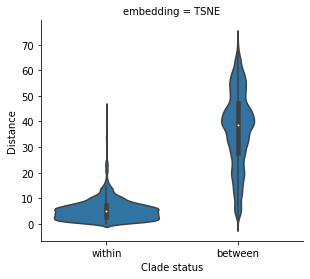

In [72]:
TSNE_violin_df = get_euclidean_data_frame(merged_tsne_df, "TSNE1", "TSNE2", "TSNE")
g = sns.FacetGrid(
    TSNE_violin_df,
    col="embedding",
    col_wrap=3,
    sharey=False,
    height=4
)
g = g.map(sns.violinplot, "clade_status", "distance", order=["within", "between"])
g.set_axis_labels("Clade status", "Distance")
plt.savefig("docs/TSNEViolinPlot" + virus_name + ".png")

In [73]:
total_df = scatterplot_xyvalues(similarity_matrix.index, similarity_matrix, merged_tsne_df, "TSNE1", "TSNE2", "TSNE")
y_values = statsmodels.nonparametric.smoothers_lowess.lowess(
    total_df["euclidean"],
    total_df["genetic"],
    frac=0.6666666666666666,
    it=3,
    delta=0.0,
    is_sorted=False,
    missing='drop',
    return_sorted=True
)

PD_Y_values = pd.DataFrame(y_values)
PD_Y_values.columns = ["LOWESS_x", "LOWESS_y"]

regression = linregress(total_df["genetic"], total_df["euclidean"])
slope, intercept, r_value, p_value, std_err = regression

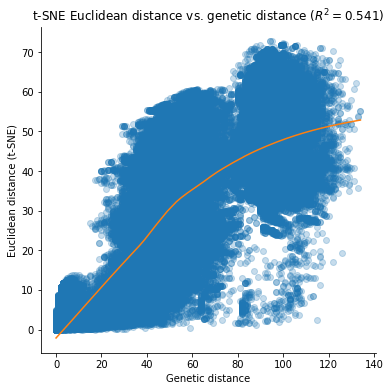

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df["genetic"], total_df["euclidean"], "o", alpha=0.25)
ax.plot(PD_Y_values["LOWESS_x"], PD_Y_values["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (t-SNE)")
ax.set_title("t-SNE Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (r_value ** 2))

sns.despine()
plt.savefig("docs/TSNEScatterplot" + virus_name + ".png")

# Running UMAP on the Dataset

In [75]:
reducer = umap.UMAP(n_neighbors=200,
        min_dist=.05,
        n_components=2,
        init="spectral")
X_transformed_umap = reducer.fit_transform(similarity_matrix)

In [76]:
UMAP_df = pd.DataFrame(X_transformed_umap,columns=['UMAP' + str(i) for i in range(1,3)])

In [77]:
UMAP_df["strain"] = similarity_matrix.index

In [78]:
UMAP_df.head()

UMAP1      UMAP2                 strain
0 -1.042353  12.586940      mex39/Mexico/2016
1  4.629141  -7.335290  DOM/2016/MA_WGS16_024
2  4.339618  -7.510780       DOM/2016/BB_0208
3  4.086901  -7.548831  DOM/2016/MA_WGS16_007
4  4.462984  -7.410495        Yokohama/1/2016

In [79]:
merged_umap_df = UMAP_df.merge(node_df, on="strain")

In [80]:
merged_umap_df.head()

UMAP1      UMAP2                 strain         date    y  \
0 -1.042353  12.586940      mex39/Mexico/2016  2016.517454  574   
1  4.629141  -7.335290  DOM/2016/MA_WGS16_024  2016.517454  393   
2  4.339618  -7.510780       DOM/2016/BB_0208  2016.303901  413   
3  4.086901  -7.548831  DOM/2016/MA_WGS16_007  2016.358658  414   
4  4.462984  -7.410495        Yokohama/1/2016  2016.386037  386   

          region             country  parent_date    parent_y  \
0  north_america              mexico  2015.017583  575.917969   
1  north_america  dominican_republic  2016.102272  393.000000   
2  north_america  dominican_republic  2016.097083  413.000000   
3  north_america  dominican_republic  2016.097083  413.000000   
4    japan_korea               japan  2015.722717  387.023438   

  clade_membership clade_membership_color  
0               c4                     c4  
1               c5                     c5  
2               c5                     c5  
3               c5                     c5  
4               c5                     c5

In [81]:
merged_umap_df.shape

(529, 11)

In [82]:
scatterplot_with_tooltip_interactive(merged_umap_df,'UMAP1','UMAP2',"UMAP1","UMAP2",['strain','clade_membership'],'clade_membership_color')

<VegaLite 3 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [83]:
list_of_data_and_titles = ['UMAP1','UMAP2']
list_of_chart = linking_tree_with_plots_brush(
    merged_umap_df,
    list_of_data_and_titles,
    list_of_data_and_titles,
    'clade_membership_color',
    ["clade_membership","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]
chart
chart.save("docs/UMAP" + virus_name + "Brush.html")
chart.save("docs/UMAP" + virus_name + "Brush.png")

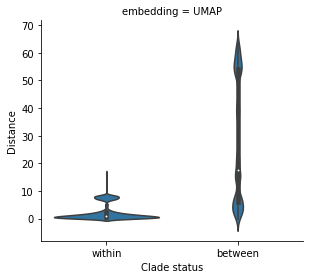

In [84]:
UMAP_violin_df = get_euclidean_data_frame(merged_umap_df, "UMAP1", "UMAP2", "UMAP")
g = sns.FacetGrid(
    UMAP_violin_df,
    col="embedding",
    col_wrap=3,
    sharey=False,
    height=4
)
g = g.map(sns.violinplot, "clade_status", "distance", order=["within", "between"])
g.set_axis_labels("Clade status", "Distance")
plt.savefig("docs/UMAPViolinPlot" + virus_name + ".png")

In [85]:
total_df = scatterplot_xyvalues(similarity_matrix.index, similarity_matrix, merged_umap_df, "UMAP1", "UMAP2", "UMAP")
y_values = statsmodels.nonparametric.smoothers_lowess.lowess(
    total_df["euclidean"],
    total_df["genetic"],
    frac=0.6666666666666666,
    it=3,
    delta=0.0,
    is_sorted=False,
    missing='drop',
    return_sorted=True
)

PD_Y_values = pd.DataFrame(y_values)
PD_Y_values.columns = ["LOWESS_x", "LOWESS_y"]

regression = linregress(total_df["genetic"], total_df["euclidean"])
slope, intercept, r_value, p_value, std_err = regression

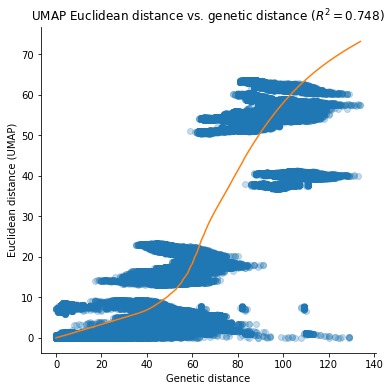

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df["genetic"], total_df["euclidean"], "o", alpha=0.25)
ax.plot(PD_Y_values["LOWESS_x"], PD_Y_values["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (UMAP)")
ax.set_title("UMAP Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (r_value ** 2))

sns.despine()
plt.savefig("docs/UMAPScatterplot" + virus_name + ".png")

# Linking all plots together clickable with Tree

In [87]:
merged_df = node_df.merge(
    principalDf,
    on="strain"
).merge(
    MDS_df,
    on="strain"
).merge(
    TSNE_df,
    on="strain"
).merge(
    UMAP_df,
    on="strain"
)

In [88]:
merged_df.shape

(529, 33)

In [89]:
merged_df.head()

strain         date  y          region    country  parent_date  \
0              SG_021  2016.703628  0  southeast_asia  singapore  2012.306769   
1            SI_BKK06  2017.684463  1  southeast_asia   thailand  2012.306769   
2               BKK07  2017.750171  2  southeast_asia   thailand  2014.673044   
3   Thailand/1610acTw  2016.835044  3  southeast_asia   thailand  2015.134275   
4  Thai/KngSG/17_D501  2017.920087  4  southeast_asia   thailand  2015.822154   

   parent_y clade_membership clade_membership_color       PCA1  ...  \
0   0.00000       unassigned             unassigned -13.181379  ...   
1   0.00000       unassigned             unassigned -17.918768  ...   
2   2.46875               c2                     c2 -17.609819  ...   
3   3.43750               c2                     c2  25.919561  ...   
4   4.37500               c2                     c2 -12.236375  ...   

        MDS5       MDS6       MDS7       MDS8       MDS9      MDS10  \
0 -14.615943  17.247056  -1.238583 -54.237441  -4.746244  13.324272   
1 -20.205744  32.021437  14.057582 -38.188936  -9.954112  49.269678   
2 -12.749466   9.011467  34.845072 -30.399731  46.546719 -34.835438   
3 -11.979489  -7.411716  21.017905 -20.365807  30.031763 -22.997136   
4   4.198223 -12.299993  21.512142 -23.946933  54.669063  -9.421342   

       TSNE1      TSNE2      UMAP1      UMAP2  
0  -0.616736 -38.104828  12.694082 -46.011433  
1   2.915341 -39.971684  12.655977 -45.953365  
2   2.403671 -32.474022  12.567100 -46.028809  
3   1.219257 -34.858536  12.608935 -46.049927  
4  10.402905 -30.786024  12.561772 -46.042717  

[5 rows x 33 columns]

In [90]:
data = linking_tree_with_plots_clickable(
    merged_df,
    ['MDS1', 'MDS2','TSNE1', 'TSNE2', 'PCA1', 'PCA2', 'UMAP1', 'UMAP2'],
    ['MDS1', 'MDS2', 'TSNE1', 'TSNE2','PCA1 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[0]*100,2)) + ")",
    'PCA2 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[1]*100,2)) + ")",'UMAP1','UMAP2'],
    'clade_membership_color:N',
    ['clade_membership'],
    ['strain','clade_membership']
)

In [91]:
data1 = linking_tree_with_plots_brush(
    merged_df,
    ['TSNE1', 'TSNE2','UMAP1', 'UMAP2'],
    ['TSNE1', 'TSNE2','UMAP1','UMAP2'],
    'clade_membership_color:N',
    ['strain','clade_membership']
)

In [92]:
TSNEUMAP = data1[0]|data1[1]|data1[2]
TSNEUMAP.save("docs/TSNEUMAPClickable" + virus_name + ".html")
TSNEUMAP

<VegaLite 3 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [93]:
PCAMDS = data[3]|data[1]|data[5]
TSNEUMAP = data[2]|data[4]
embeddings = alt.vconcat(PCAMDS,TSNEUMAP)
embeddings
fullChart = alt.hconcat(data[0],embeddings)
fullChart.save("docs/FullLinkedChartClickable" + virus_name + ".html")
fullChart.save("docs/FullLinkedChartClickable" + virus_name + ".png")
fullChart

<VegaLite 3 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


## Scatterplots for all embeddings 
Concatenating all embedding data frames to plot genetic vs Euclidean distance for each embedding

In [94]:
umap_df = scatterplot_xyvalues(similarity_matrix.index, similarity_matrix, merged_umap_df, "UMAP1", "UMAP2", "UMAP")
tsne_df = scatterplot_xyvalues(similarity_matrix.index, similarity_matrix, merged_tsne_df, "TSNE1", "TSNE2", "TSNE")
mds_df = scatterplot_xyvalues(similarity_matrix.index, similarity_matrix, merged_mds_df, "MDS1", "MDS2", "MDS")
pca_df = scatterplot_xyvalues(similarity_matrix.index, similarity_matrix, merged_pca_df, "PCA1", "PCA2", "PCA")

y_values_umap = statsmodels.nonparametric.smoothers_lowess.lowess(
    umap_df["euclidean"],
    umap_df["genetic"],
    frac=0.6666666666666666,
    it=3,
    delta=0.0,
    is_sorted=False,
    missing='drop',
    return_sorted=True
)

y_values_tsne = statsmodels.nonparametric.smoothers_lowess.lowess(
    tsne_df["euclidean"],
    tsne_df["genetic"],
    frac=0.6666666666666666,
    it=3,
    delta=0.0,
    is_sorted=False,
    missing='drop',
    return_sorted=True
)

y_values_mds = statsmodels.nonparametric.smoothers_lowess.lowess(
    mds_df["euclidean"],
    mds_df["genetic"],
    frac=0.6666666666666666,
    it=3,
    delta=0.0,
    is_sorted=False,
    missing='drop',
    return_sorted=True
)

y_values_pca = statsmodels.nonparametric.smoothers_lowess.lowess(
    pca_df["euclidean"],
    pca_df["genetic"],
    frac=0.6666666666666666,
    it=3,
    delta=0.0,
    is_sorted=False,
    missing='drop',
    return_sorted=True
)

PD_Y_values_umap = pd.DataFrame(y_values_umap)
PD_Y_values_umap.columns = ["LOWESS_x", "LOWESS_y"]

regression_umap = linregress(umap_df["genetic"], umap_df["euclidean"])
slope, intercept, r_value_umap, p_value, std_err = regression_umap

PD_Y_values_tsne = pd.DataFrame(y_values_tsne)
PD_Y_values_tsne.columns = ["LOWESS_x", "LOWESS_y"]

regression_tsne = linregress(tsne_df["genetic"], tsne_df["euclidean"])
slope, intercept, r_value_tsne, p_value, std_err = regression_tsne

PD_Y_values_mds = pd.DataFrame(y_values_mds)
PD_Y_values_mds.columns = ["LOWESS_x", "LOWESS_y"]

regression_mds = linregress(mds_df["genetic"], mds_df["euclidean"])
slope, intercept, r_value_mds, p_value, std_err = regression_mds

PD_Y_values_pca = pd.DataFrame(y_values_pca)
PD_Y_values_pca.columns = ["LOWESS_x", "LOWESS_y"]

regression_pca = linregress(pca_df["genetic"], pca_df["euclidean"])
slope, intercept, r_value_pca, p_value, std_err = regression_pca

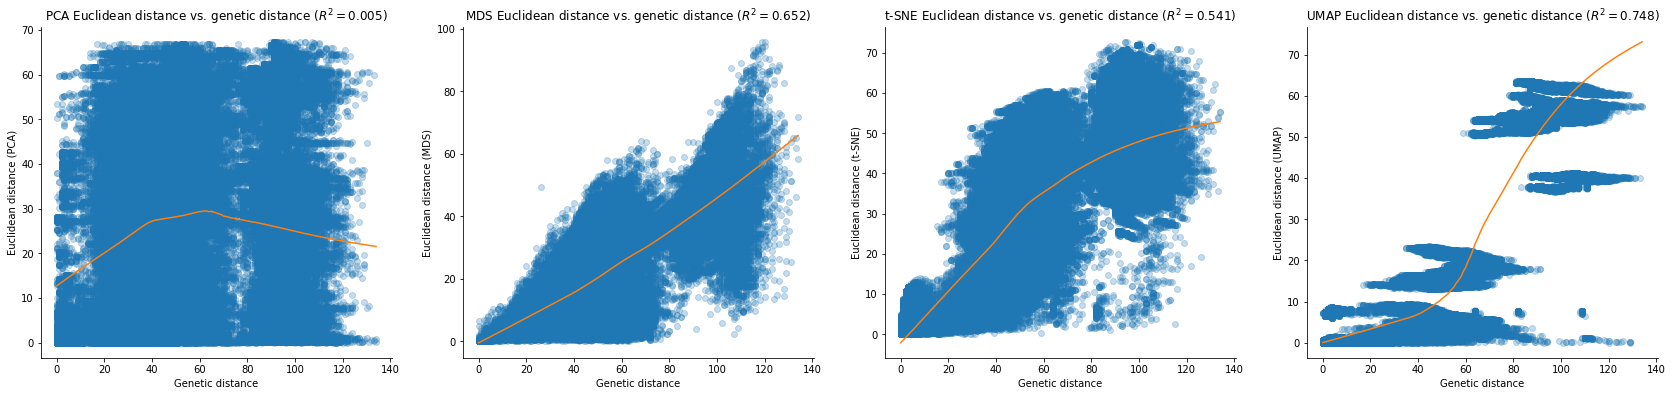

In [95]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
fig.tight_layout(pad=4.0)

ax1.plot(pca_df["genetic"], pca_df["euclidean"], "o", alpha=0.25)
ax1.plot(PD_Y_values_pca["LOWESS_x"], PD_Y_values_pca["LOWESS_y"], label="LOESS")

ax1.set_xlabel("Genetic distance")
ax1.set_ylabel("Euclidean distance (PCA)")
ax1.set_title("PCA Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (r_value_pca ** 2))

ax2.plot(mds_df["genetic"], mds_df["euclidean"], "o", alpha=0.25)
ax2.plot(PD_Y_values_mds["LOWESS_x"], PD_Y_values_mds["LOWESS_y"], label="LOESS")

ax2.set_xlabel("Genetic distance")
ax2.set_ylabel("Euclidean distance (MDS)")
ax2.set_title("MDS Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (r_value_mds ** 2))

ax3.plot(tsne_df["genetic"], tsne_df["euclidean"], "o", alpha=0.25)
ax3.plot(PD_Y_values_tsne["LOWESS_x"], PD_Y_values_tsne["LOWESS_y"], label="LOESS")

ax3.set_xlabel("Genetic distance")
ax3.set_ylabel("Euclidean distance (t-SNE)")
ax3.set_title("t-SNE Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (r_value_tsne ** 2))

ax4.plot(umap_df["genetic"], umap_df["euclidean"], "o", alpha=0.25)
ax4.plot(PD_Y_values_umap["LOWESS_x"], PD_Y_values_umap["LOWESS_y"], label="LOESS")

ax4.set_xlabel("Genetic distance")
ax4.set_ylabel("Euclidean distance (UMAP)")
ax4.set_title("UMAP Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (r_value_umap ** 2))


sns.despine()
plt.savefig("docs/FullScatterplot" + virus_name + ".png")

## Within- and between-clade Euclidean distances for all embeddings

Use the complete embedding data frame to calculate pairwise Euclidean distances between samples and plot the results in a single figure.

In [96]:
data_frames = [
    get_euclidean_data_frame(merged_df, "PCA1", "PCA2", "PCA"),
    get_euclidean_data_frame(merged_df, "MDS1", "MDS2", "MDS"),
    get_euclidean_data_frame(merged_df, "TSNE1", "TSNE2", "t-SNE"),
    get_euclidean_data_frame(merged_df, "UMAP1", "UMAP2", "UMAP"),
]

Extract pairwise genetic (Hamming) distances corresponding to the records sampled above. This step assumes that the original merged data frame is indexed from zero to N for N total samples in the same order as the similarity matrix.

In [97]:
genetic_distances = squareform(similarity_matrix)

In [98]:
data_frames.append(pd.DataFrame({
    "distance": genetic_distances,
    "clade_status": data_frames[0]["clade_status"].values,
    "embedding": "genetic"
}))

In [99]:
len(data_frames)

5

In [100]:
euclidean_data_frame = pd.concat(data_frames)

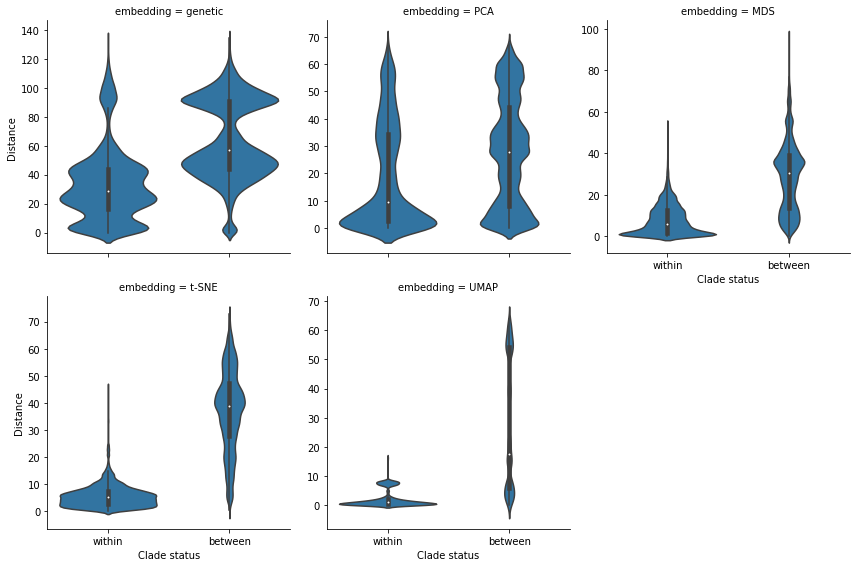

In [101]:
g = sns.FacetGrid(
    euclidean_data_frame,
    col="embedding",
    col_wrap=3,
    col_order=["genetic", "PCA", "MDS", "t-SNE", "UMAP"],
    sharey=False,
    height=4
)
g = g.map(sns.violinplot, "clade_status", "distance", order=["within", "between"])
g.set_axis_labels("Clade status", "Distance")
plt.savefig("docs/FullViolinPlot" + virus_name + ".png")

In [102]:
PCA_df = euclidean_data_frame[euclidean_data_frame.embedding == "PCA"]
MDS_df = euclidean_data_frame[euclidean_data_frame.embedding == "MDS"]
TSNE_df = euclidean_data_frame[euclidean_data_frame.embedding == "t-SNE"]
UMAP_df = euclidean_data_frame[euclidean_data_frame.embedding == "UMAP"]
genetic_df = euclidean_data_frame[euclidean_data_frame.embedding == "genetic"]

In [103]:
genetic_df

distance clade_status embedding
0           66.0       within   genetic
1           68.0      between   genetic
2           69.0      between   genetic
3           67.0      between   genetic
4           64.0      between   genetic
...          ...          ...       ...
139651      60.0       within   genetic
139652      62.0       within   genetic
139653       2.0       within   genetic
139654      64.0       within   genetic
139655      70.0       within   genetic

[139656 rows x 3 columns]

In [104]:
genetic_df['distance'].mean()

59.92054047087128

In [105]:
median_genetic_within = genetic_df[genetic_df.clade_status == "within"].median()
median_genetic_between = genetic_df[genetic_df.clade_status == "between"].median()

In [106]:
median_PCA_within = PCA_df[PCA_df.clade_status == "within"].median()
median_PCA_between = PCA_df[PCA_df.clade_status == "between"].median()

In [107]:
median_MDS_within = MDS_df[MDS_df.clade_status == "within"].median()
median_MDS_between = MDS_df[MDS_df.clade_status == "between"].median()

In [108]:
median_TSNE_within = TSNE_df[TSNE_df.clade_status == "within"].median()
median_TSNE_between = TSNE_df[TSNE_df.clade_status == "between"].median()

In [109]:
median_UMAP_within = UMAP_df[UMAP_df.clade_status == "within"].median()
median_UMAP_between = UMAP_df[UMAP_df.clade_status == "between"].median()

In [110]:
def ratioFunction(num1, num2):
    ratio12 = int(num1/num2)
    return ratio12

In [111]:
genetic_ratio = ratioFunction(median_genetic_between,median_genetic_within)
print(genetic_ratio)

1


In [112]:
PCA_ratio = ratioFunction(median_PCA_between,median_PCA_within)
print(PCA_ratio)

2


In [113]:
MDS_ratio = ratioFunction(median_MDS_between,median_MDS_within)
print(MDS_ratio)

5


In [114]:
TSNE_ratio = ratioFunction(median_TSNE_between,median_TSNE_within)
print(TSNE_ratio)

7


In [115]:
UMAP_ratio = ratioFunction(median_UMAP_between,median_UMAP_within)
print(UMAP_ratio)

17


## Missing Bases Analysis

(low importance)
- use similarity_matrix.index and cluster by K-means
- find accuracy by taking into account the total amount of relationships between clusters and taking the percentage of them which are STILL correct (ex. within/between stays within/between)
    - this allows you to reuse code if needed

In [116]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=7, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=None, algorithm='auto')
kmeans_data= kmeans.fit(X_transformed_tsne)

In [117]:
merged_tsne_df_copy = merged_tsne_df.copy()
merged_tsne_df_copy["clade_membership"] = kmeans_data.labels_

In [118]:
brush = alt.selection(type='interval', resolve='global')
chart = alt.Chart(merged_tsne_df_copy).mark_circle(size=60).encode(
    x=alt.X("TSNE1", title="TSNE1"),
    y=alt.X("TSNE2", title="TSNE2"),
    color=alt.Color('clade_membership',
               scale=alt.Scale(
        domain = ["0", "1", "2", "3", "4", "5", "6"],
        range=['blue', 'orange', "red", "light blue", "green", "yellow", "purple"])),
    tooltip=["strain", "clade_membership"]
).interactive()
chart.display()

<VegaLite 3 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [119]:
chart2 = scatterplot_with_tooltip_interactive(merged_tsne_df,'TSNE1','TSNE2',"TSNE1","TSNE2",['strain','clade_membership'],'clade_membership_color')

In [120]:
chart | chart2

<VegaLite 3 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [121]:
merged_tsne_df_copy = get_euclidean_data_frame(merged_tsne_df_copy, "TSNE1", "TSNE2", "TSNE")

In [122]:
diff_btw_df = TSNE_violin_df["clade_status"] == merged_tsne_df_copy["clade_status"]
diff_btw_df.sum()

132715

In [123]:
((diff_btw_df.sum() / TSNE_violin_df.shape[0])*100)

95.0299306868305

In [124]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(TSNE_violin_df["clade_status"], merged_tsne_df_copy["clade_status"])
confusion_df = pd.DataFrame(confusion)

In [125]:
confusion_df.columns = ["False", "True"]
confusion_df.index = ["False", "True"]
confusion_df

False   True
False  115000   4872
True     2069  17715

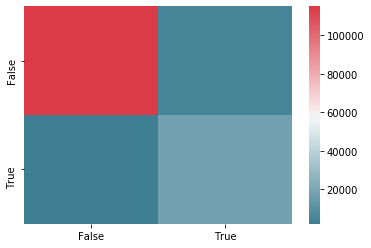

In [126]:
sns.heatmap(confusion_df, cmap = sns.diverging_palette(220, 10, as_cmap=True))

In [127]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=7, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=None, algorithm='auto')
kmeans_data= kmeans.fit(X_transformed_umap)

In [128]:
merged_umap_df_copy = merged_umap_df.copy()
merged_umap_df_copy["clade_membership"] = kmeans_data.labels_

In [129]:
brush = alt.selection(type='interval', resolve='global')
chart = alt.Chart(merged_umap_df_copy).mark_circle(size=60).encode(
    x=alt.X("UMAP1", title="UMAP1"),
    y=alt.X("UMAP2", title="UMAP2"),
    color=alt.Color('clade_membership',
               scale=alt.Scale(
        domain = ["0", "1", "2", "3", "4", "5", "6"],
        range=['blue', 'orange', "red", "light blue", "green", "yellow", "purple"])),
    tooltip=["strain", "clade_membership"]
).interactive()
chart.display()

<VegaLite 3 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [130]:
chart2 = scatterplot_with_tooltip_interactive(merged_umap_df,'UMAP1','UMAP2',"UMAP1","UMAP2",['strain','clade_membership'],'clade_membership_color')

In [131]:
chart | chart2

<VegaLite 3 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [132]:
merged_umap_df_copy = get_euclidean_data_frame(merged_umap_df_copy, "UMAP1", "UMAP2", "UMAP")

In [133]:
diff_btw_df = UMAP_violin_df["clade_status"] == merged_umap_df_copy["clade_status"]
diff_btw_df.sum()

127113

In [134]:
((diff_btw_df.sum() / UMAP_violin_df.shape[0])*100)

91.01864581543221

In [135]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(UMAP_violin_df["clade_status"], merged_umap_df_copy["clade_status"])
confusion_df = pd.DataFrame(confusion)

In [136]:
confusion_df.columns = ["False", "True"]
confusion_df.index = ["False", "True"]
confusion_df

False   True
False  112897   6975
True     5568  14216

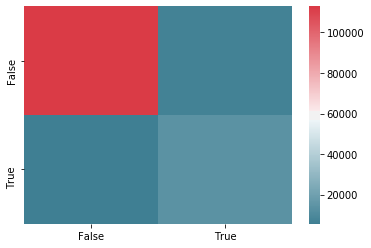

In [137]:
sns.heatmap(confusion_df, cmap = sns.diverging_palette(220, 10, as_cmap=True))

In [138]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=7, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=None, algorithm='auto')
kmeans_data= kmeans.fit(X_transformed_mds)

In [139]:
merged_mds_df_copy = merged_mds_df.copy()
merged_mds_df_copy["clade_membership"] = kmeans_data.labels_

In [140]:
brush = alt.selection(type='interval', resolve='global')
chart = alt.Chart(merged_mds_df_copy).mark_circle(size=60).encode(
    x=alt.X("MDS1", title="MDS1"),
    y=alt.X("MDS2", title="MDS2"),
    color=alt.Color('clade_membership',
               scale=alt.Scale(
        domain = ["0", "1", "2", "3", "4", "5", "6"],
        range=['blue', 'orange', "red", "light blue", "green", "yellow", "purple"])),
    tooltip=["strain", "clade_membership"]
).interactive()
chart.display()

<VegaLite 3 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [141]:
chart2 = scatterplot_with_tooltip_interactive(merged_mds_df,'MDS1','MDS2',"MDS1","MDS2",['strain','clade_membership'],'clade_membership_color')

In [142]:
chart | chart2

<VegaLite 3 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [143]:
merged_mds_df_copy = get_euclidean_data_frame(merged_mds_df_copy, "MDS1", "MDS2", "MDS")

In [144]:
diff_btw_df = MDS_violin_df["clade_status"] == merged_mds_df_copy["clade_status"]
diff_btw_df.sum()

132266

In [145]:
((diff_btw_df.sum() / MDS_violin_df.shape[0])*100)

94.70842641920146

In [146]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(MDS_violin_df["clade_status"], merged_mds_df_copy["clade_status"])
confusion_df = pd.DataFrame(confusion)

In [147]:
confusion_df.columns = ["False", "True"]
confusion_df.index = ["False", "True"]
confusion_df

False   True
False  114295   5577
True     1813  17971

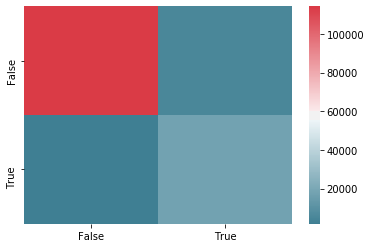

In [148]:
sns.heatmap(confusion_df, cmap = sns.diverging_palette(220, 10, as_cmap=True))